### Preparing the data
Load mortality rates, transform them into log rates.

In [19]:
# load packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression


In [22]:
# choose region, sex, last_year, and number of years on which forecasting should be performed
n_years = 5
last_year = 2019
reg_select = 1146 # Moscow oblast
sex_select = 'M' # males

# choose number of years to be forecasted
forecast_steps = 2


In [23]:
# load and filter data
mx = pd.read_csv('mx.csv')
mx = mx[
    (mx['year'] <= last_year) &
    (mx['year'] > last_year - n_years) & 
    (mx['reg'] == reg_select) & 
    (mx['sex'] == sex_select)
]
mx


,year,reg,sex,x,mx
37278,2015,1146,M,0,0.005319
37279,2015,1146,M,1,0.000226
37280,2015,1146,M,5,0.000181
37281,2015,1146,M,10,0.000249
37282,2015,1146,M,15,0.000837
...,...,...,...,...,...
49604,2019,1146,M,65,0.037323
49605,2019,1146,M,70,0.050549
49606,2019,1146,M,75,0.073730
49607,2019,1146,M,80,0.107423


In [24]:
# transform mx to log_mx
mx['log_mx'] = np.log(mx['mx'])
mx


,year,reg,sex,x,mx,log_mx
37278,2015,1146,M,0,0.005319,-5.236470
37279,2015,1146,M,1,0.000226,-8.394976
37280,2015,1146,M,5,0.000181,-8.617014
37281,2015,1146,M,10,0.000249,-8.298058
37282,2015,1146,M,15,0.000837,-7.085686
...,...,...,...,...,...,...
49604,2019,1146,M,65,0.037323,-3.288146
49605,2019,1146,M,70,0.050549,-2.984812
49606,2019,1146,M,75,0.073730,-2.607346
49607,2019,1146,M,80,0.107423,-2.230981


### Calculating model input parameters ($a_{x}$, $b_{x}$, $k_{t}$)
Calcualte four parameters:
- $a_{x}$ is the average over time of ln($m_{x,t}$) for each age;
- $A_{x,t}$ = ln($m_{x,t}$) - $a_{x}$ (used in SVD);
- $k_{t}$ = ($u_{1,1}$, $u_{2,1}$, ..., $u_{t,1}$) (derived form U from svd($A_{x,t}$));
- $b_{x}$ = ($v_{1,1}$, $v_{1,2}$, ..., $v_{1,x}$) (derived from V* from svd($A_{x,t}$)).

svd($A_{x,t}$) = USV* is the the singular value decomposition.<br>
x denotes age, t - year.

In [25]:
# ax
df_ax = mx[['x','log_mx']].groupby('x').mean('log_mx').reset_index().rename(columns={'log_mx':'ax'})
df_ax


,x,ax
0,0,-5.392230
1,1,-8.317540
2,5,-8.792487
3,10,-8.253825
4,15,-7.179790
5,20,-6.689744
6,25,-6.121010
7,30,-5.554122
8,35,-5.187175
9,40,-4.930351


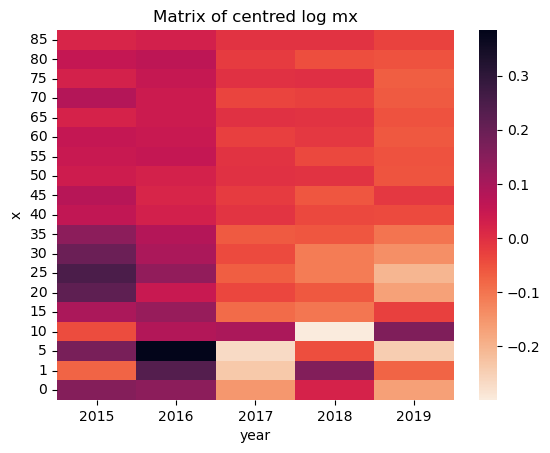

In [26]:
# Axt
Axt = mx.merge(df_ax)
Axt['Axt'] = Axt['log_mx'] - Axt['ax']
Axt = Axt[['year','x','Axt']]

# heatmap
Axt_heatmap = Axt.pivot(columns='year', index='x', values='Axt').sort_index(ascending = False)

plt.title('Matrix of centred log mx')
sns.heatmap(Axt_heatmap, cmap = 'rocket_r')
plt.yticks(rotation=0);


In [27]:
Axt = Axt.pivot(columns='year', index='x', values='Axt')
Axt


year,2015,2016,2017,2018,2019
x,,,,,
0,0.155760,0.143274,-0.153524,0.022202,-0.167712
1,-0.077435,0.232129,-0.235280,0.158021,-0.077435
5,0.175474,0.384149,-0.269433,-0.046290,-0.243900
10,-0.044233,0.083761,0.094306,-0.298996,0.165162
15,0.094104,0.125853,-0.087501,-0.103386,-0.029070
20,0.218307,0.046658,-0.035689,-0.061007,-0.168269
25,0.248572,0.133537,-0.067443,-0.111253,-0.203413
30,0.196903,0.093991,-0.041524,-0.110056,-0.139315
35,0.141948,0.079973,-0.063687,-0.056844,-0.101390


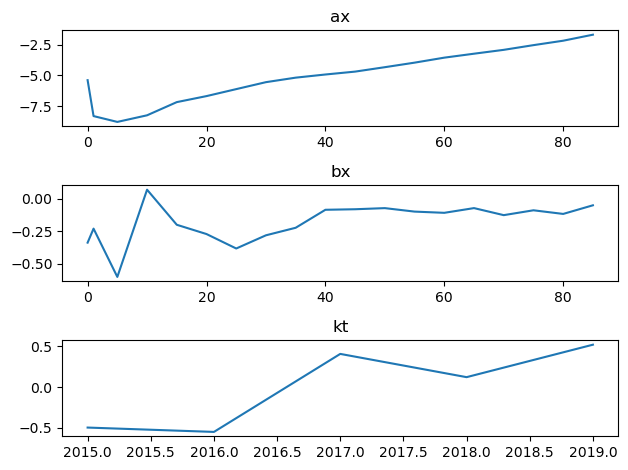

In [28]:
# compute SVD
U, S, V = np.linalg.svd(Axt.to_numpy())

# extract ax
ax = df_ax['ax'].to_list()

# extract bx
bx = list(U[:,0])

# extract kt
kt = list(V[0,:])

# extract x and t
t = list(range(last_year - n_years + 1, last_year + 1))
x = [0,1] + list(range(5,90,5))

# plot results
plt.subplot(3, 1, 1)
plt.title('ax')
plt.plot(x, ax)

plt.subplot(3, 1, 2)
plt.title('bx')
plt.plot(x, bx)

plt.subplot(3, 1, 3)
plt.title('kt')
plt.plot(t, kt)

plt.tight_layout()

### Forecast $k_{t}$
In Lee-Carter model $k_{t}$ is forecasted using standard univariate ARIMA model to n additional years. But here we will use linear regression for the simplicity.

In [29]:
# Fit model
model = LinearRegression()
model.fit(np.array(t).reshape(-1, 1), kt)

forecast = list(model.predict(np.array(list(range(last_year + 1, last_year + forecast_steps + 1))).reshape(-1, 1)))
forecast


[0.8114953404078733, 1.081993787210422]

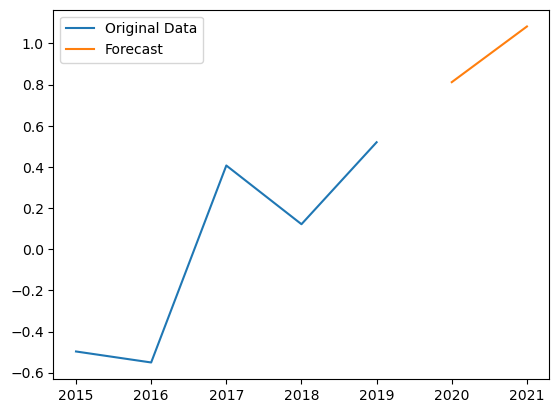

In [30]:
# check the result of forecasting kt
plt.plot(t, kt, label='Original Data')
plt.plot(range(last_year + 1, last_year + forecast_steps + 1), forecast, label='Forecast')
plt.legend()
plt.show()


### Calculate forecasted age-specific mortality
Use the forecasted $k_{t+n}$, with the original $b_{x}$, and $a_{x}$ to calculate the forecasted mortality rate for each age:<br>
$m_{x,t+n}$  = exp($a_{x}$ + $k_{t+n}$$b_{x}$).

In [31]:
forecast = kt + forecast

mx_forecasted = pd.DataFrame()
for i in range(len(forecast)):
    mx_forecasted_i = []
    for j in range(len(x)):
        mx_forecasted_i.append(np.exp(ax[j] + forecast[i] * bx[j]))
    mx_forecasted_i = pd.DataFrame({'x': x, 'mx':mx_forecasted_i})
    mx_forecasted_i['year'] = last_year - n_years + 1 + i
    mx_forecasted = pd.concat([mx_forecasted, mx_forecasted_i])

mx_forecasted['forecasted'] = 1
mx_forecasted = mx_forecasted[['year','x','mx','forecasted']]
mx_forecasted.head(5)


,year,x,mx,forecasted
0,2015,0,0.005380,1
1,2015,1,0.000274,1
2,2015,5,0.000205,1
3,2015,10,0.000251,1
4,2015,15,0.000841,1


### Compare real data with the results
Compare forecasted values with real values of mx. We can also calculate the deviations of the real data from the forecasted. The measure might be called 'excess mortality'.

In [32]:
# load and filter data
mx = pd.read_csv('mx.csv')
mx = mx[
    (mx['year'] > last_year - n_years) & 
    (mx['reg'] == reg_select) & 
    (mx['sex'] == sex_select)
]
mx['forecasted'] = 0
mx = mx[['year','x','mx','forecasted']]
mx.head(5)


,year,x,mx,forecasted
37278,2015,0,0.005319,0
37279,2015,1,0.000226,0
37280,2015,5,0.000181,0
37281,2015,10,0.000249,0
37282,2015,15,0.000837,0


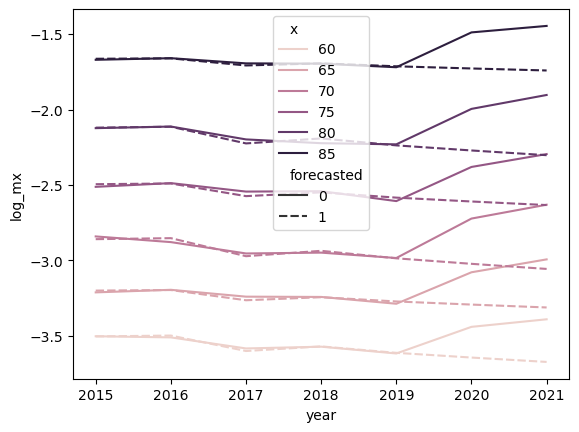

In [33]:
# compare real and forecasted values
result = pd.concat([mx, mx_forecasted]).reset_index()[['year','x','mx','forecasted']]
result['log_mx'] = np.log(result['mx'])

sns.lineplot(data = result[result['x'] > 55], x = 'year', y = 'log_mx', hue = 'x', style = 'forecasted');


### Excess mortality by age for 2020-2021
Calculate relative (observed to expected mx ratio) and absoule (difference between observed and expected mx per 1000 person-years) values of excess mortality.

In [34]:
# calculate values of excess mortality
result_f = result[(result['forecasted'] == 1) & (result['year'] > last_year)]
em = result_f.merge(result[result['forecasted'] == 0], on = ['year','x'])[['year','x','mx_x','mx_y']].rename(
    columns = {
        'mx_x' : 'mx_expected',
        'mx_y' : 'mx_observed'
    }
)
em['excess_mort_abs'] = (em['mx_observed'] - em['mx_expected']) * 1000 # per 1000 person-years
em['excess_mort_rel'] = em['mx_observed'] / em['mx_expected'] # ratio
em


,year,x,mx_expected,mx_observed,excess_mort_abs,excess_mort_rel
0,2020,0,0.003464,0.003297,-0.167095,0.951764
1,2020,1,0.000203,0.000235,0.032164,1.158570
2,2020,5,0.000093,0.000137,0.043675,1.467984
3,2020,10,0.000276,0.000234,-0.041647,0.848913
4,2020,15,0.000648,0.000657,0.008778,1.013542
5,2020,20,0.000999,0.001491,0.492359,1.493029
6,2020,25,0.001612,0.002141,0.529484,1.328563
7,2020,30,0.003085,0.003427,0.342375,1.110994
8,2020,35,0.004666,0.005392,0.725630,1.155502
9,2020,40,0.006749,0.008051,1.301569,1.192841


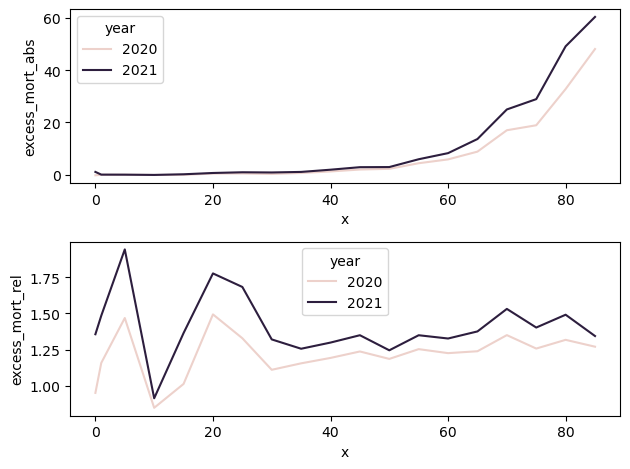

In [35]:
# visualize excess mortality
plt.subplot(2, 1, 1)
sns.lineplot(data = em, x = 'x', y = 'excess_mort_abs', hue = 'year')

plt.subplot(2, 1, 2)
sns.lineplot(data = em, x = 'x', y = 'excess_mort_rel', hue = 'year')

plt.tight_layout()
